In [1]:
import os
import shutil
import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
img_width = 32
img_height = 32

clock_path = os.path.join("data", "clock")
crocodile_path = os.path.join("data", "crocodile")

classes=['Crocodile', 'Clock']

## Загрузим модель и построим предсказания

In [3]:
with open("classifier.json", "r") as f:
    m_js = f.read()
classifier = model_from_json(m_js)
classifier.load_weights("classifier.h5")

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [4]:
def get_files_list(dir_path):
    return [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

## Построим предсказания для случайных часов и крокодила

In [5]:
clock_images = get_files_list(clock_path)
crocodile_images = get_files_list(crocodile_path)

In [19]:
def plot_image_and_predict(image_path):    
    img = image.load_img(image_path, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    plt.imshow(img)

    prediction = classifier.predict(x)[0,0]
    print('{} with probability: {:.2f}%'.format(
        classes[int(prediction < 0.5)],
        (1 - prediction if prediction < 0.5 else prediction) * 100)
    )

Clock with probability: 78.38%


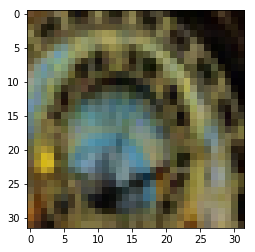

In [20]:
clock_img = np.random.choice(clock_images, 1)[0]
plot_image_and_predict(os.path.join(clock_path, clock_img))

Crocodile with probability: 88.84%


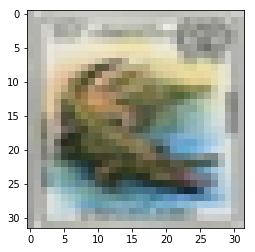

In [21]:
crocodile_img = np.random.choice(crocodile_images, 1)[0]
plot_image_and_predict(os.path.join(crocodile_path, crocodile_img))

## 2. Попробуем найти изображения максимально похожие на часы и на крокодила

Построим предсказания для часов и крокодилов

In [25]:
clock_prediction = []
for c in clock_images:
    image_path = os.path.join(clock_path, c)
    img = image.load_img(image_path, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    clock_prediction.append((classifier.predict(x)[0,0], image_path))
    
    
crocodile_prediction = []
for c in crocodile_images:
    image_path = os.path.join(crocodile_path, c)
    img = image.load_img(image_path, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    crocodile_prediction.append((classifier.predict(x)[0,0], image_path))

### 2.1. Предположим, что сеть выдает заведомо правильный результат, тогда изображения максимально похожие на часы и на крокодила будут иметь вероятность близкую к 0.5

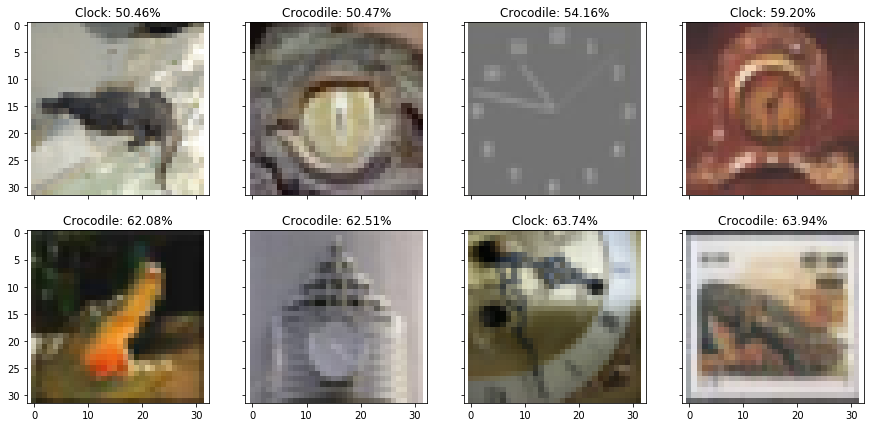

In [107]:
prediction = clock_prediction + crocodile_prediction
prediction.sort(key= lambda x: abs(x[0] - 0.5))

x, y = 2, 4
fig, axis = plt.subplots(x, y, sharey=True, sharex=True, figsize=(15, 7))
for i, p in enumerate(prediction[:x * y]):
    img = image.load_img(p[1], target_size=(img_height, img_width))
    c = i // y, i % y
    axis[c].imshow(img)
    axis[c].set_title('{}: {:.2f}%'.format(
        classes[int(p[0] < 0.5)],
        (1 - p[0] if p[0] < 0.5 else p[0]) * 100
    ))

Здесь можно отметить, что картинки похожие на крокодила и на часы, по мнению нейросети, могут быть:
    - стрелки похожие на пасть и пасть похожая на стрелки
    - с глазом крокодила (похоже на обод часов)

### 2.2. Теперь предположим, что разметчик данных и нейросеть могут ошибаться равновероятно. Тогда максимально похожие на часы и на крокодила картинки будут:

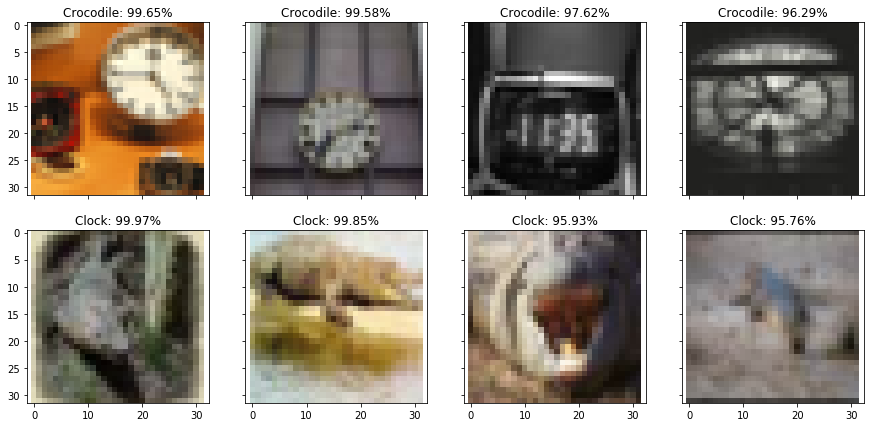

In [64]:
clock_prediction.sort(key= lambda x: x[0], reverse=True)
crocodile_prediction.sort(key= lambda x: x[0])

x, y = 2, 4
prediction = clock_prediction[:y] + crocodile_prediction[:y]

fig, axis = plt.subplots(x, y, sharey=True, sharex=True, figsize=(15, 7))
for i, p in enumerate(prediction):
    img = image.load_img(p[1], target_size=(img_height, img_width))
    c = i // y, i % y
    axis[c].imshow(img)
    axis[c].set_title('{}: {:.2f}%'.format(
        classes[int(p[0] < 0.5)],
        (1 - p[0] if p[0] < 0.5 else p[0]) * 100
    ))

В этом случае можно сказать, что на картинках с крокодилами довольно сложно найти самого крокодила, а на некоторых закруглены края, что дает возможность предпологать, что это обод часов

### Вывод: предположение 2 не валидно, так как предположение о том, что разметчик данных ошибается, ложно. Предположение 1 дало достаточно хороший результат, многие из этих картинок и вравду частично похожи на оба класса

## 3. Теперь попробуем сенерировать изображение, похожее и на крокодила и на часы

### Попробуем создать автоенкодер

Загрузим данные

In [158]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Flatten, Activation, Input, Reshape
from tensorflow.python.keras.layers import Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, UpSampling1D
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.regularizers import L1L2
from sklearn.model_selection import train_test_split

In [159]:
batch_size = 64

In [160]:
def load_images(image_path):
    images = []
    image_list = get_files_list(image_path)
    for i in image_list:
        img = image.load_img(os.path.join(image_path, i), target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x /= 255
        images.append(x)
    return images

clock_images_list = load_images(clock_path)
crocodile_images_list = load_images(crocodile_path)

X = np.array(clock_images_list + crocodile_images_list)
y = np.array([0]*len(clock_images_list) + [1]*len(crocodile_images_list))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

Обучим нейросеть

In [172]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (4, 4), activation='relu', padding='same')(input_img)
x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)


input_encoded = Input(shape=(8, 8, 3))
x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_encoded)
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Модели
encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

In [173]:
encoder.compile(optimizer='adam', loss='binary_crossentropy')
decoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_val, X_val))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 3s - loss: 0.6847 - val_loss: 0.6562
Epoch 2/100
900/900 [==============================] - 1s - loss: 0.6386 - val_loss: 0.6284
Epoch 3/100
900/900 [==============================] - 1s - loss: 0.6147 - val_loss: 0.6148
Epoch 4/100
900/900 [==============================] - 1s - loss: 0.6031 - val_loss: 0.6067
Epoch 5/100
900/900 [==============================] - 1s - loss: 0.5965 - val_loss: 0.6015
Epoch 6/100
900/900 [==============================] - 1s - loss: 0.5906 - val_loss: 0.5960
Epoch 7/100
900/900 [==============================] - 1s - loss: 0.5876 - val_loss: 0.6200
Epoch 8/100
900/900 [==============================] - 1s - loss: 0.5909 - val_loss: 0.5950
Epoch 9/100
900/900 [==============================] - 1s - loss: 0.5830 - val_loss: 0.5890
Epoch 10/100
900/900 [==============================] - 1s - loss: 0.5794 - val_loss: 0.5904
Epoch 11/100
900/900 [===========

900/900 [==============================] - 1s - loss: 0.5563 - val_loss: 0.5655
Epoch 89/100
900/900 [==============================] - 1s - loss: 0.5555 - val_loss: 0.5651
Epoch 90/100
900/900 [==============================] - 1s - loss: 0.5553 - val_loss: 0.5655
Epoch 91/100
900/900 [==============================] - 1s - loss: 0.5554 - val_loss: 0.5650
Epoch 92/100
900/900 [==============================] - 1s - loss: 0.5552 - val_loss: 0.5651
Epoch 93/100
900/900 [==============================] - 1s - loss: 0.5553 - val_loss: 0.5653
Epoch 94/100
900/900 [==============================] - 1s - loss: 0.5554 - val_loss: 0.5649
Epoch 95/100
900/900 [==============================] - 1s - loss: 0.5553 - val_loss: 0.5649
Epoch 96/100
900/900 [==============================] - 1s - loss: 0.5551 - val_loss: 0.5649
Epoch 97/100
900/900 [==============================] - 1s - loss: 0.5551 - val_loss: 0.5651
Epoch 98/100
900/900 [==============================] - 1s - loss: 0.5604 - val_los

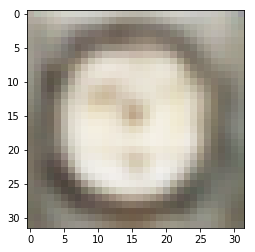

In [174]:
img = image.load_img("data/clock/10291.png", target_size=(img_height, img_width))
x = image.img_to_array(img)
x /= 255.
x = np.expand_dims(x, axis=0)

x = autoencoder.predict(x)
plt.imshow(x.reshape(32, 32, 3))

### Попробуем выделить главные компоненты картинок крокодила и часов через encoder, слить их воедино и получить картинку через decoder

Classifier predict: 0.50


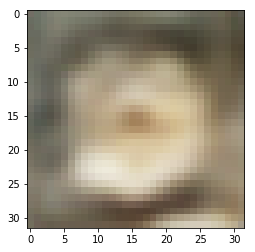

In [177]:
img = image.load_img("data/clock/10291.png", target_size=(img_height, img_width))
x = image.img_to_array(img)
x /= 255.
x = np.expand_dims(x, axis=0)
x1 = encoder.predict(x)

img = image.load_img("data/crocodile/11165.png", target_size=(img_height, img_width))
x = image.img_to_array(img)
x /= 255.
x = np.expand_dims(x, axis=0)
x2 = encoder.predict(x)

x = decoder.predict((x1 + x2) / 2)
plt.imshow(x.reshape(32, 32, 3))
print("Classifier predict: {:.2f}".format(classifier.predict(x)[0,0]))

Как видно, получается создать картинку которая одинаково похожа на крокодила и часы одновременно, но, к сожалению, она не очень информативна